# Первичная обработка основных признаков и обучение на наих Ridge-регрессии со стандартными параметрами. (Закончила)

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree 

sns.set(style="darkgrid")

In [207]:
data = pd.read_csv("data.csv", encoding='latin1')

Цели для обработки данных:

*   Remove features associated with >85% missing values
*   Remove constant features
*   Remove duplicates features
*   Remove duplicate rows
*   Remove highly collinear features

# Вспомагательные функции для графиков:



In [208]:
# https://towardsdatascience.com/financial-data-analysis-bf4b5e78c45c
# Эта функция строит графики с учетом того, категориальный ли признак

def plot_feature(col_name, isContinuous, df): 
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=90)
    
    # Plot without loan status
    if isContinuous:
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name)
    plt.xticks(rotation = 90)

# Plot with loan status
    if isContinuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by Loan Status')
    else:
        data = df.groupby(col_name)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = col_name, y = 'proportion', hue= "loan_status", data = data, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    plt.show()

# **Описание данных:**

**loan_amnt** - запрашиваемая у банка сумма для кредита \

**funded_amnt** - накопительная сумма \

**funded_amnt_inv** - накопительная сумма для инвестора \

**term** - на какой промежуток выдан кредит

**int_rate** - процентная ставка \

**installment** - первоначальный взнос \

**grade** - оценка кредитного риска

**emp_title** - профессия

**emp_length** - опыт работы

**home_ownership** - тип жилья

**annual_inc** - годовые доходы \

**verification_status** - статус верификации

**issue_d** - месяц в который получено финансирование

**purpose** - цель

**addr_state** - кто выдает кредит (гос сторона)

**dti** - это процент ежемесячного валового дохода потребителя, который идет на выплату долгов \

**delinq_2yrs** - просрочка платежей более чем на 30 дней за последние два года \

**earliest_cr_line** - месяц открытия самой ранней кредитной истории

**inq_last_6mths** - количество обращений кредитора(то есть Банка) в бюро кредитных историй, если клиент ходит по разным банкам и просит кредиты, то это говорит, что этому клиенту либо отказывают, либо он решил набрать везде кредитов. Как правило это негативно влияет \

**open_acc** - это количество открытых кредитов

**revol_bal** - общий оборотный остаток

**revol_util** - доля утилизации. Клиенту выдали кредитную карту с лимитом 100 рублей, он уже потратил 40 рублей, revol_util будет равен 40/100 = 0.4

**total_acc** - видимо все кредиты и активные, и закрытые

**out_prncp** - оставшаяся непогашенная сумма

**total_pymnt** - полученные на сегодня платежи

**loan_status** - текущий статус кредита (закрыт не закрыт)

**risk** - выадем не выдаем

# Обработка данных

In [209]:
data.drop_duplicates(inplace= True) # Сразу удалим все дубликаты

Посмотрим на пропущенные данные:

In [210]:
data.isna().sum()

id                         0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_title              29565
emp_length             22615
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                      148
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             1
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util               213
total_acc                  0
out_prncp                  0
total_pymnt                0
loan_status                0
risk                       0
dtype: int64

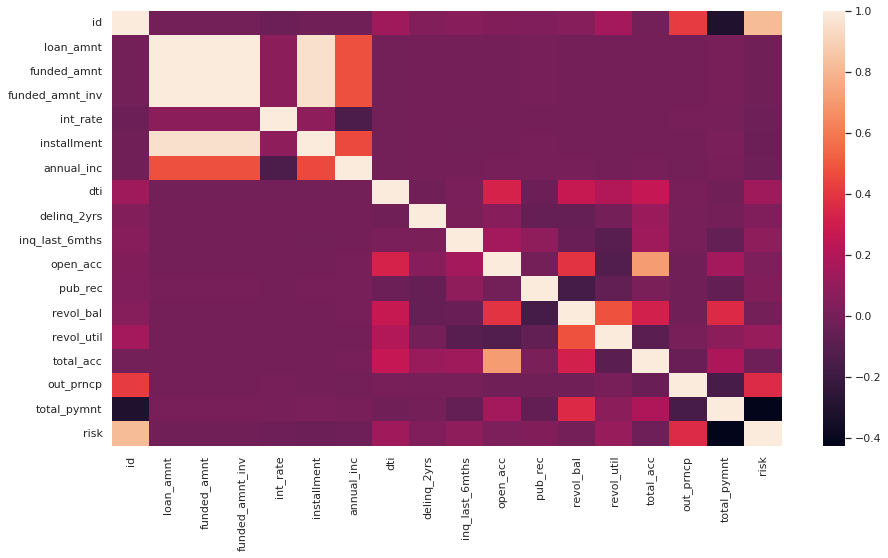

In [211]:
corr_matrix = data.corr(method = 'spearman')
# Я посмотрела разные methods но они все в принципе одинаковые

plt.figure(figsize = (15, 8))
sns.heatmap(corr_matrix.T)

plt.show()

### risk

In [212]:
data['risk'].value_counts()

0    207036
1    103668
Name: risk, dtype: int64

Важно было убедиться, что у нас достаточное количество дефолтов для исследования и разница между признаками не превышает 70%.

### loan_amnt

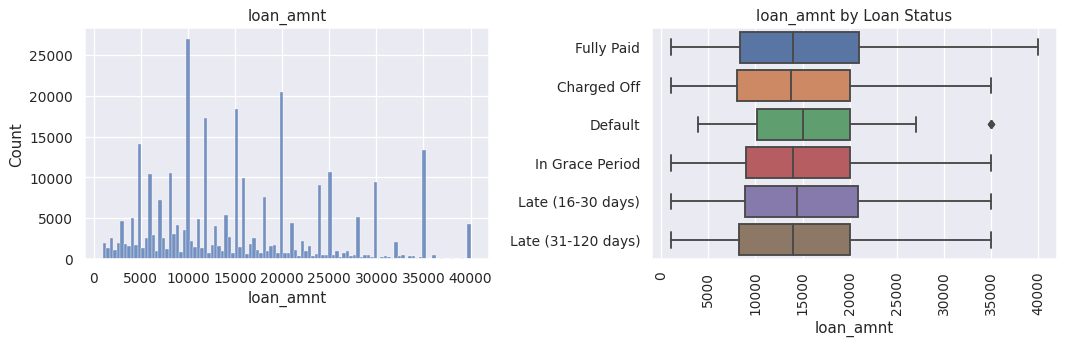

In [213]:
plot_feature('loan_amnt', True, data)

Сложно тут оценивать выбросы, потому что в принципе сумма займа не должна сильно зависеть от вероятности дефолта, поэтому пока оставлю так. Возможно, в будущем для рассмотрения стоит оставить только Fully Paid и Charged Off.

In [214]:
data = data.loc[(data['loan_status'].isin(['Fully Paid', 'Charged Off']))]

### annual_inc

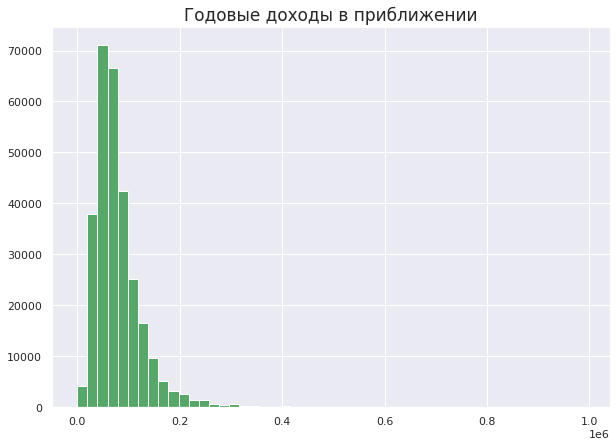

In [215]:
data[data['annual_inc'] < 1000000]['annual_inc'].hist(bins=50, figsize=(10, 7), color='g')

plt.title('Годовые доходы в приближении', size = 17)
plt.show()

### int_rate

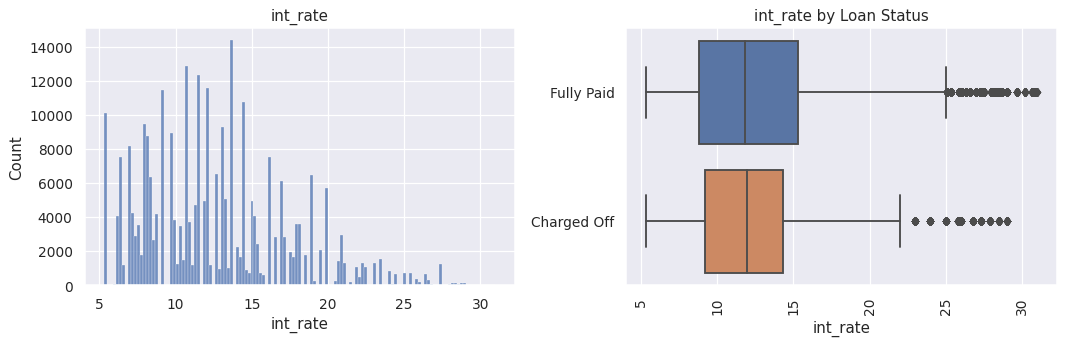

In [216]:
plot_feature('int_rate', True, data)

### installment

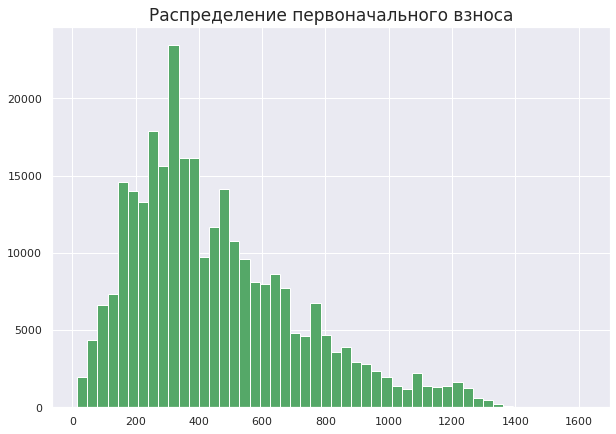

In [217]:
data['installment'].hist(color = 'g', bins=50, figsize=(10, 7))

plt.title('Распределение первоначального взноса', size = 17)
plt.show()

### funded_amnt и funded_amnt_inv

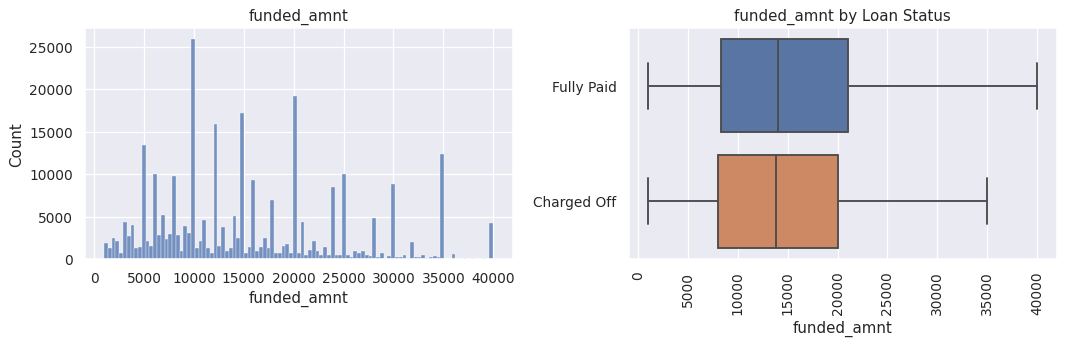

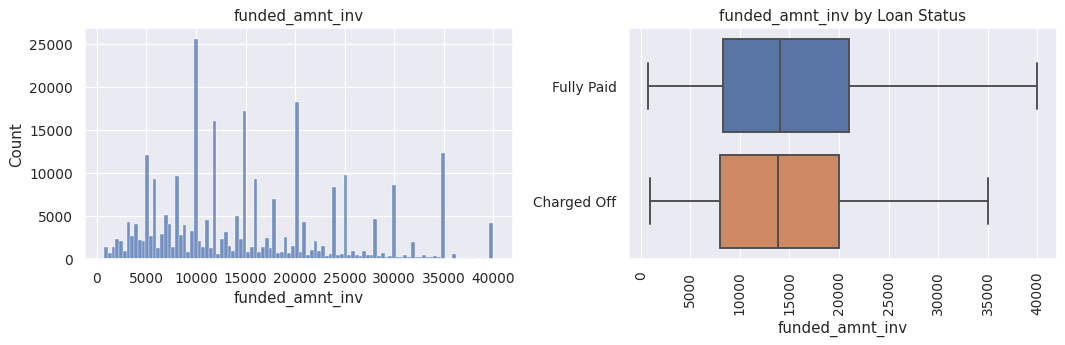

In [218]:
plot_feature('funded_amnt', True, data)
plot_feature('funded_amnt_inv', True, data)

Не уверена, нужны ли нам два настолько близких признака. Я бы оставила только funded_amnt, потому что по ощущениям данные там чуть более полные.

In [219]:
data.drop('funded_amnt_inv', axis=1,  inplace=True) 

### pub_rec

In [220]:
data.drop('pub_rec', axis=1, inplace=True) 
# не поняли что это за признак

### emp_title

In [221]:
data['emp_title'].value_counts()

Teacher                         5309
Manager                         4609
Owner                           2539
Registered Nurse                2261
Driver                          2032
                                ... 
Lineman/Troubleman                 1
Senior SEC Reporting Analyst       1
surgery scheduler                  1
PBX Operator,V.A.                  1
Economist                          1
Name: emp_title, Length: 86769, dtype: int64

Слишком много уникальных профессий и вероятнее всего они не отражают ничего дельного, поэтому этот признак можно удалить.

In [222]:
data.drop('emp_title', axis=1, inplace=True) 

### home_ownership

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


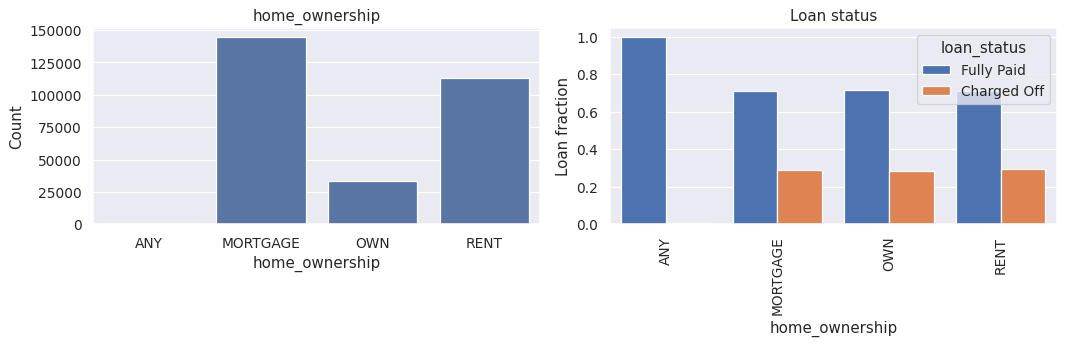

In [223]:
plot_feature('home_ownership', False, data)

Возможно на категориальных данных, которых сравнительно меньше остальных, модель будет сильно переобучаться, поэтому я думаю удалю "ANY"

In [224]:
data = data.loc[data['home_ownership'] != "ANY"]
#  data = data.drop(np.where(data['home_ownership'] == "ANY")[0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


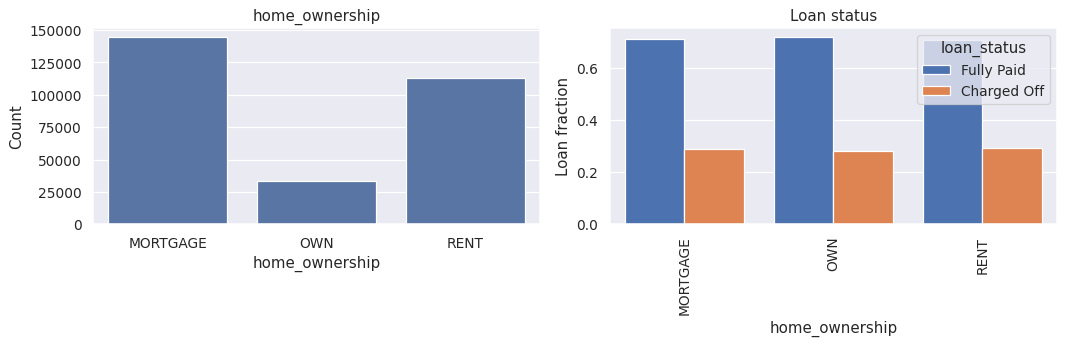

In [225]:
plot_feature('home_ownership', False, data)

### emp_length

Так как меньше 10% признаков в emp_title и  emp_lenght пропущены, не будем выкидывать эти признаки, а просто заменим значения пустой строкой.

In [226]:
data.fillna(value={'emp_title': ''}, inplace = True)

Ниже с **emp_length** надо подумать, может лучше сделать просто количество лет и не делать это категориальным признаком

In [227]:
data['emp_length'].unique()

array(['10+ years', '6 years', '4 years', '< 1 year', '2 years',
       '9 years', nan, '5 years', '3 years', '7 years', '1 year',
       '8 years'], dtype=object)

In [228]:
data.fillna(value={'emp_length': 'No'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


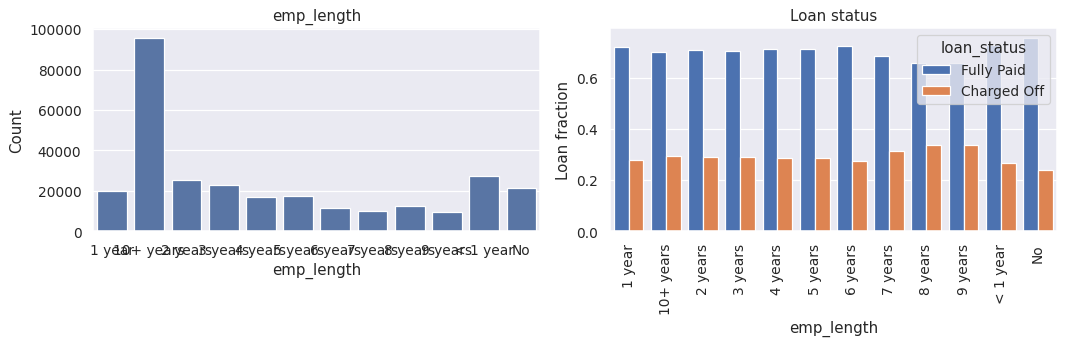

In [229]:
plot_feature('emp_length', False, data)

### **dti**

Мне кажется один из важнейших признаков который должен очень сильно коррелировать - это процент с дохода, который идет на выплату. Очень красивое распределение

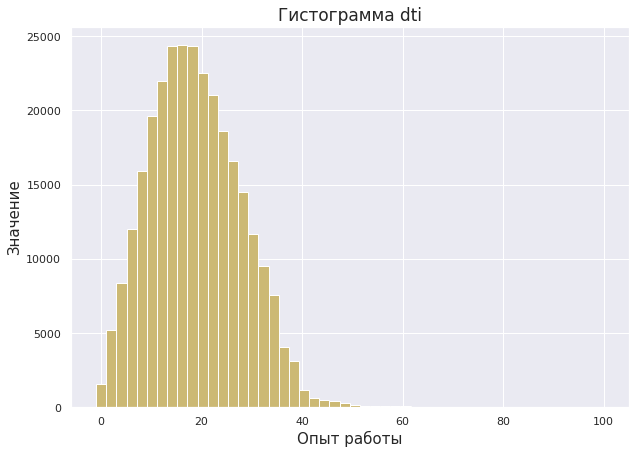

In [230]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

In [231]:
data.fillna(value={'dti': 0, 'revol_util': 0}, inplace = True)

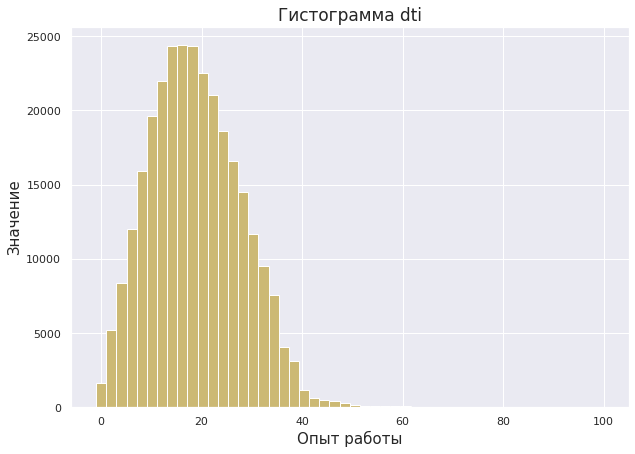

In [232]:
plt.ticklabel_format(style='plain')
# plt.plot(data['dti'], )
# data['dti'].hist(bins=50, facecolor='g', figsize=(10, 7))
data[data['dti'] < 100]['dti'].hist(bins=50, color='y', figsize=(10, 7))

plt.title('Гистограмма dti', size = 17)
plt.xlabel('Опыт работы', size = 15)
plt.ylabel('Значение', size = 15)
plt.show()

Заполнение нулями ничего сильно не повредило, поэтому супер.

### **grade**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


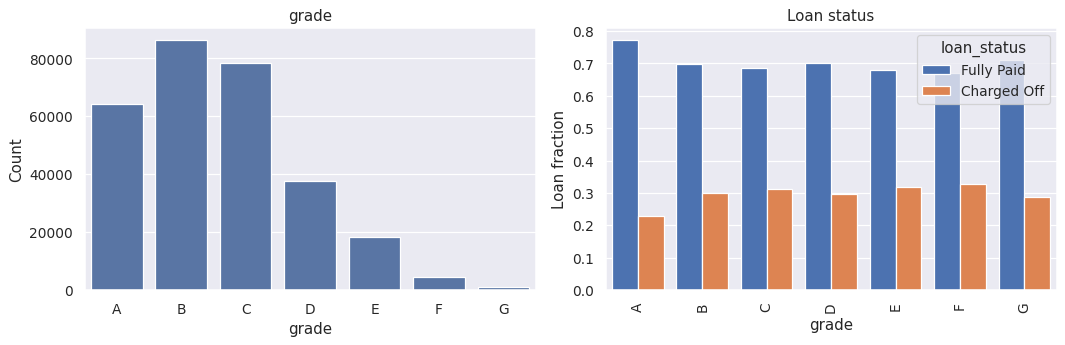

In [233]:
plot_feature('grade', False, data)

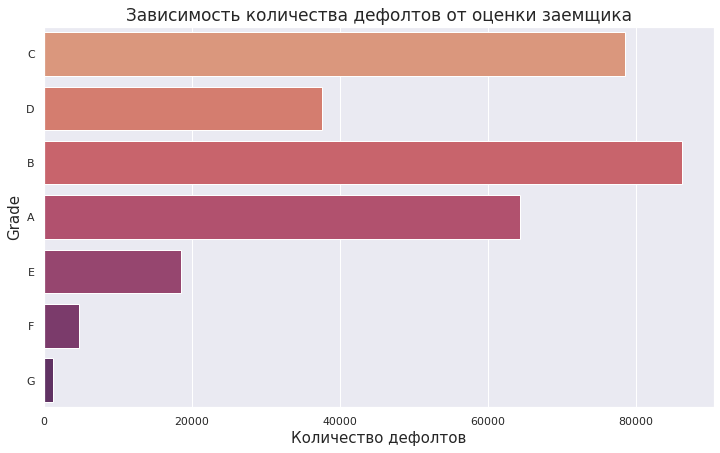

In [234]:
plt.figure(figsize=(12, 7))
sns.countplot(data = data, y = data['grade'], palette="flare")

plt.title('Зависимость количества дефолтов от оценки заемщика', size = 17)
plt.xlabel('Количество дефолтов', size = 15)
plt.ylabel('Grade', size = 15)
plt.show()

### **issue_d** и **earliest_cr_line**

Два признака с датами, которые возможно стоит перевести в data type, либо я вычитала что можно оставить тольк месяц, из-за того что мы работаем с данными всего за пару лет. (И перевести в категориальные признаки)

In [235]:
data['issue_d'].unique()

array(['Dec-18', 'Nov-18', 'Oct-18', 'Mar-16', 'Feb-16', 'Jan-16',
       'Nov-15', 'Dec-15', 'Oct-15'], dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


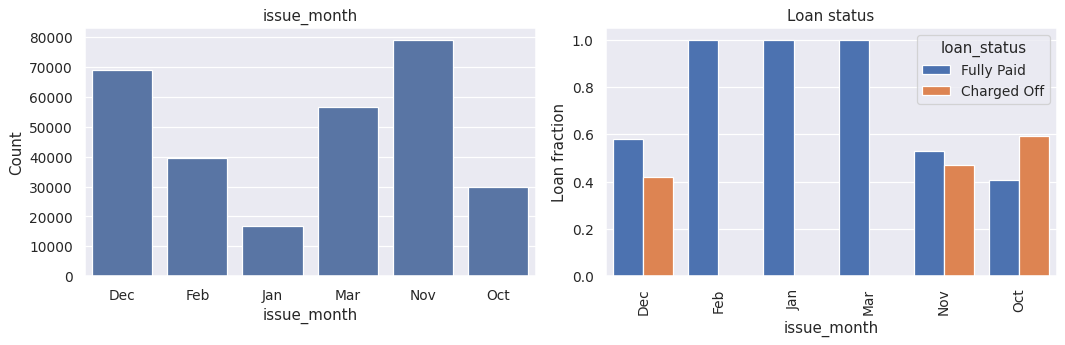

In [236]:
data['issue_month'] = pd.Series(data.issue_d).str.replace(r'-\d+', '')
plot_feature('issue_month', False, data)

Пока получается не очень понятно, почему такое распределение по выплатам в зависимости от месяца...

In [237]:
# data['issue_d'] = pd.to_datetime(data['issue_d'], format='%b-%y')
# data['earliest_cr_line'] = pd.to_datetime(data['issue_d'], format='%b-%y')

Пока непонятно, как это может помочь, не буду строить график из-за слишком многого количества признаков, но возможно они сойдут за хорошие категориальные.

In [238]:
data['earliest_cr_line']

0         Jan-12
1         Jun-09
2         Feb-99
3         Dec-03
4         Oct-97
           ...  
310352    Nov-97
310353    Sep-05
310354    Aug-02
310355    Nov-92
310356    Aug-06
Name: earliest_cr_line, Length: 290961, dtype: object

In [239]:
data['earliest_cr_year'] = data.earliest_cr_line.str.replace(r'\w+-', '').astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


### **loan_status**

Что-то я потеряла, где я этот признак уже обрабатывала, но повторюсь, что я оставила только два типа: выплачено или нет.

In [240]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

### **purpose**

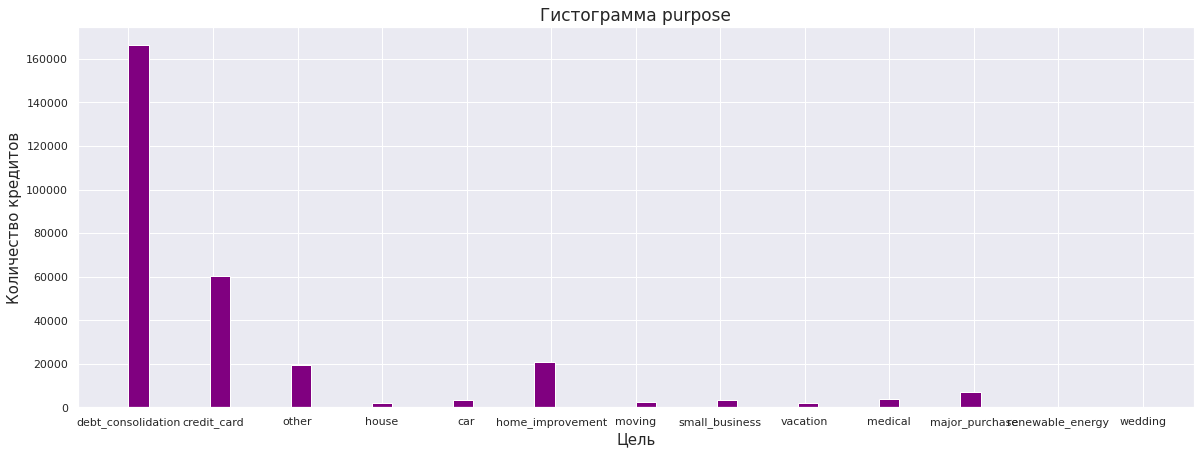

In [241]:
plt.ticklabel_format(style='plain')
data['purpose'].hist(bins=50, color='purple', figsize=(20, 7))

plt.title('Гистограмма purpose', size = 17)
plt.xlabel('Цель', size = 15)
plt.ylabel('Количество кредитов', size = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


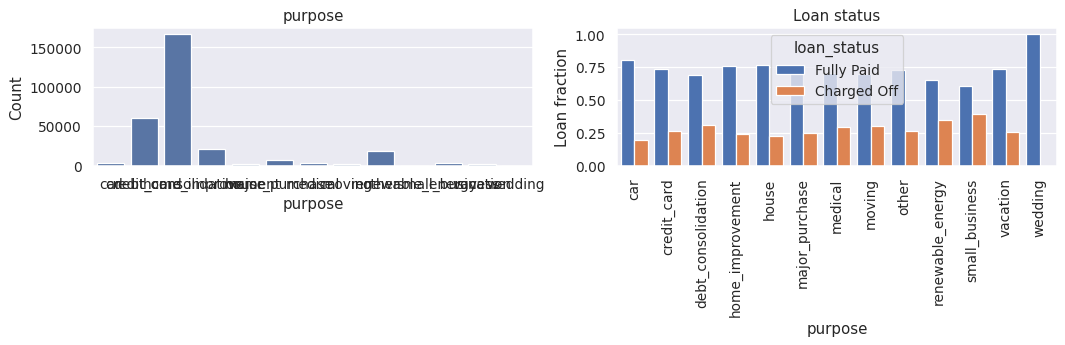

In [242]:
plot_feature('purpose', False, data)

In [243]:
data['purpose'].value_counts()

debt_consolidation    166400
credit_card            60272
home_improvement       20907
other                  19426
major_purchase          7128
medical                 3777
car                     3252
small_business          3182
moving                  2276
vacation                2161
house                   1975
renewable_energy         203
wedding                    2
Name: purpose, dtype: int64

блин реально столько людей берут в долг чтобы погашать другие долги...

### **verification_status**

In [244]:
data['verification_status']

0            Not Verified
1         Source Verified
2         Source Verified
3         Source Verified
4            Not Verified
               ...       
310352           Verified
310353       Not Verified
310354    Source Verified
310355           Verified
310356    Source Verified
Name: verification_status, Length: 290961, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


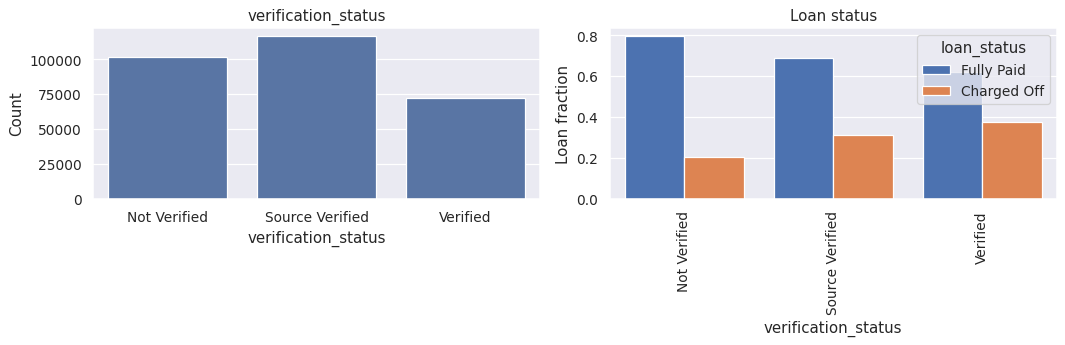

In [245]:
plot_feature('verification_status', False, data)

Очень странно, что у неверефицированных намного больший процент успешных выплат, хотя ожидается наоборот.

### **term**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


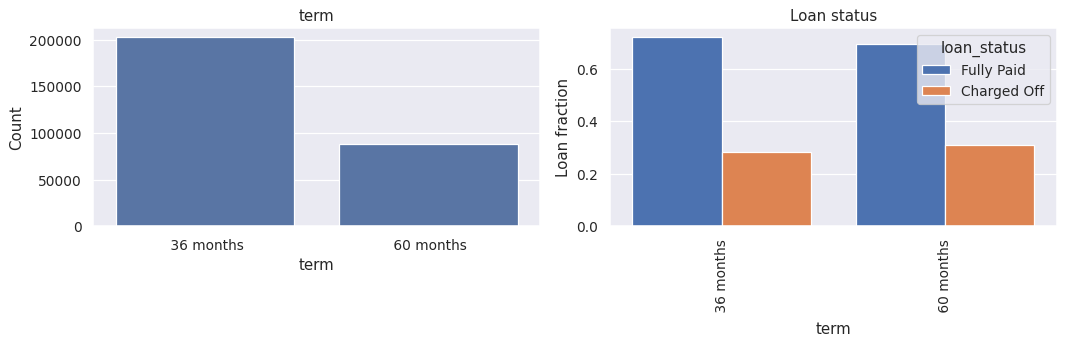

In [246]:
plot_feature('term', False, data)

Ничего особенного

### **addr_state**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


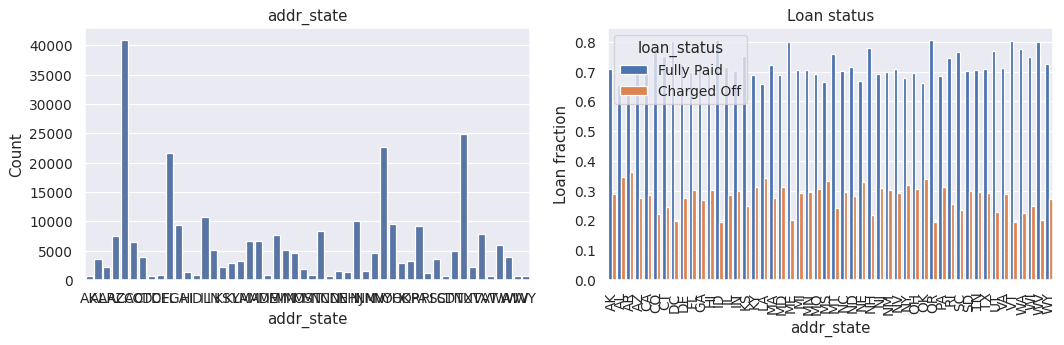

In [247]:
plot_feature('addr_state', False, data)

Есть где разгуляться, хорошо видно зависимости от региона в погашении кредита.

### **delinq_2yrs** and **inq_last_6mths**

Не могу придумать, как это может помочь, поэтому удалю данные.

In [248]:
# data.drop('delinq_2yrs', axis=1, inplace=True) 

In [249]:
# data.drop('inq_last_6mths', axis=1, inplace=True) 

### **open_acc**

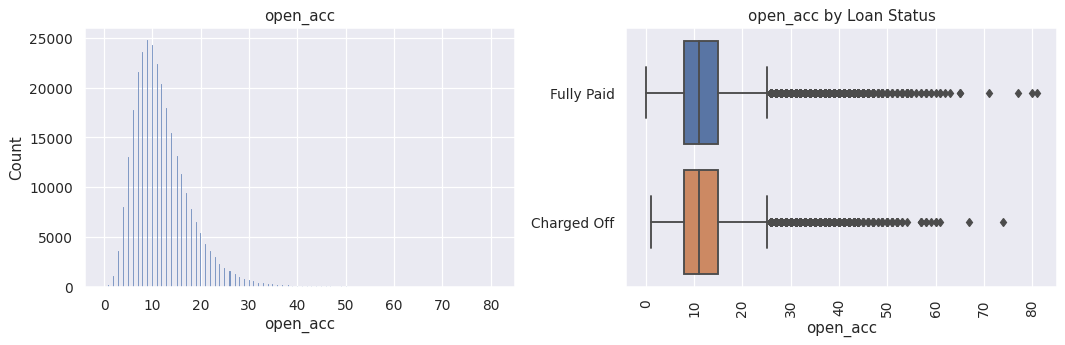

In [250]:
plot_feature('open_acc', True, data)

### **revol_util**

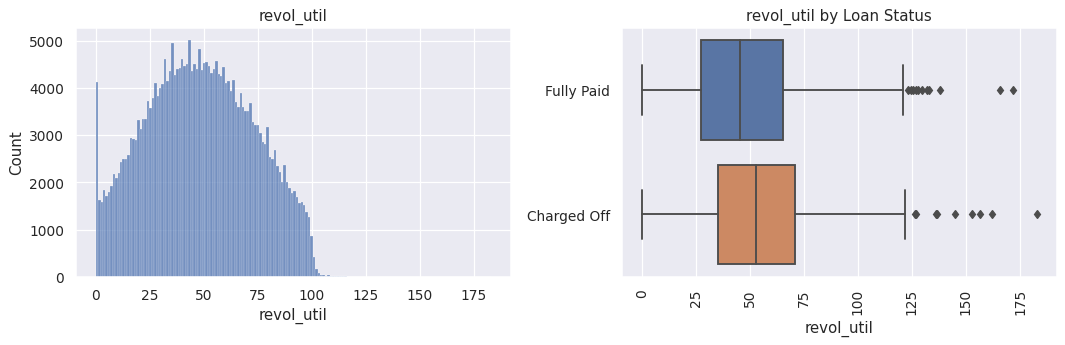

In [251]:
plot_feature('revol_util', True, data)

### **total_acc**

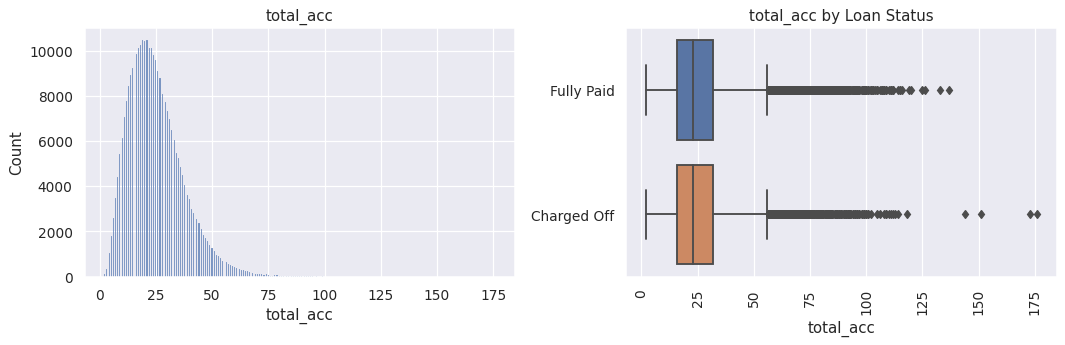

In [252]:
plot_feature('total_acc', True, data)

### **out_prncp**

In [253]:
data['out_prncp']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
310352    0.0
310353    0.0
310354    0.0
310355    0.0
310356    0.0
Name: out_prncp, Length: 290961, dtype: float64

Долго не могла понять что произошло, но оказалось что когда я оставила только два типа статусов: выплачено и нет, то все данные в которых был еще какой-то остаток удалились. Пока что я не планирую оставлять больше двух статусов, поэтому этот признак можно полностью удалить.

In [254]:
data.drop('out_prncp', axis=1, inplace=True) 

### **total_pymnt**

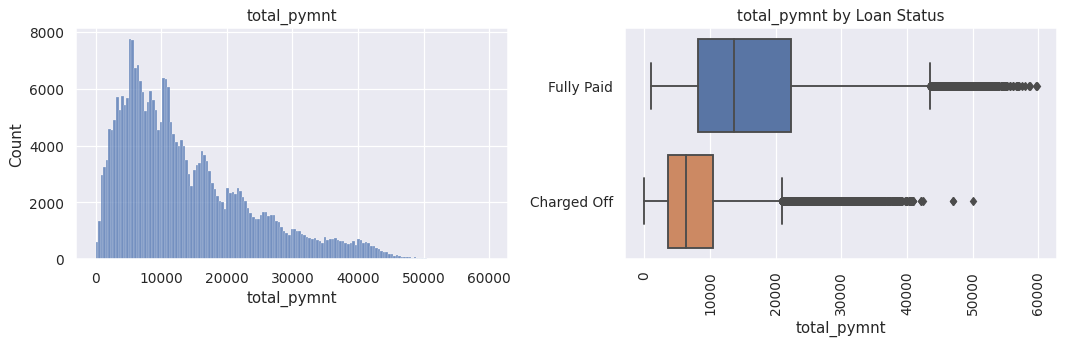

In [255]:
plot_feature('total_pymnt', True, data)

In [256]:
data.drop('total_pymnt', axis=1, inplace=True) 

### **ID**

In [257]:
data.drop('id', axis=1, inplace=True) 

### Итог обработки всех признаков:

Финально посмотрим на матрицу корреляции после обработки всех признаков:

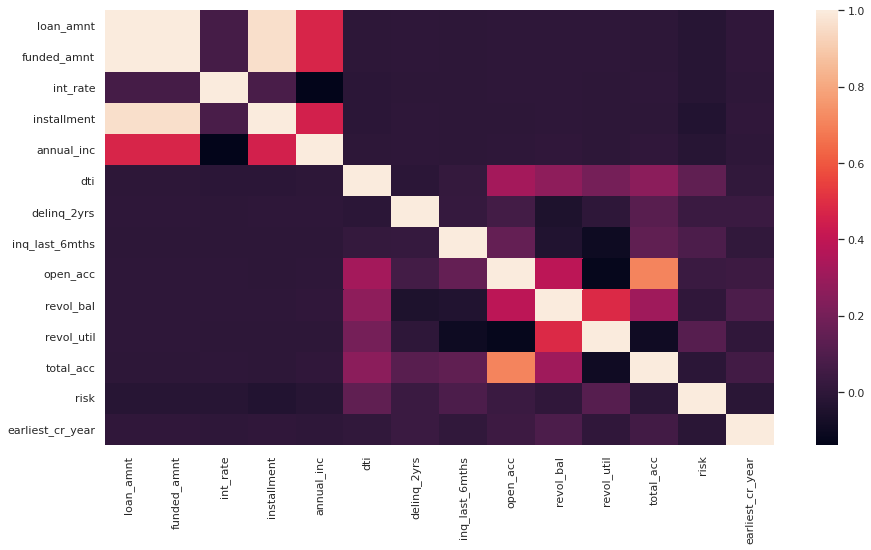

In [258]:
corr_matrix = data.corr(method = 'spearman')

plt.figure(figsize = (15, 8), )
sns.heatmap(corr_matrix.T)

plt.show()

Матрица конечно грустненькая какая-то получилась...

# Дерево решений с бинарной целевой переменной

In [263]:
# x = data[['term', 'grade', 'emp_length', 'home_ownership', 'loan_amnt', 
#          'funded_amnt', 'int_rate', 'installment', 'dti']]

# y = data['risk']


# # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

# tree = DecisionTreeClassifier(max_depth = 2)
# tree.fit(x, y)

In [264]:
# plt.figure(figsize=(10,8), dpi=150)
#  plot_tree(tree, feature_names=X.columns)

# Ridge-регрессия с параметрами по умолчанию


In [259]:
categorical = ['term', 'grade', 'emp_length', 'home_ownership']
numeric_features = ['loan_amnt', 'int_rate', 'funded_amnt', 'installment', 'dti']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps = [
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

x = data[['term', 'grade', 'emp_length', 'home_ownership', 'loan_amnt', 
         'funded_amnt', 'int_rate', 'installment', 'dti']]

y = data['risk']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

model = pipeline.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)


print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test, squared=False))

Train RMSE = 0.4235
Test RMSE = 0.4237


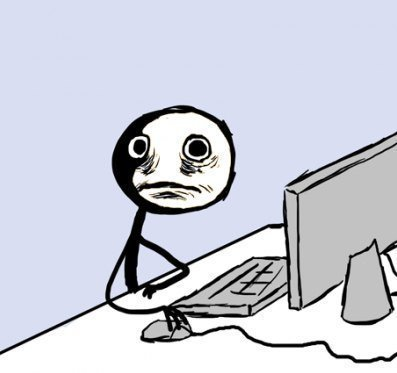